In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [3]:
model_path_name = "test_model"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [4]:
if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)
    print(f"Model blurb", file=text_file)

In [5]:
dataset = pd.read_pickle("datasets/base_dataset.pkl")

In [6]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

15791.2
1973.9


In [7]:
train_index_stop = 15893 # this is the first index of a new pitcher
val_index_stop = 17898 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [8]:
train_X = training_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
train_y = training_set['RUNPASS']

val_X = validation_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
val_y = validation_set['RUNPASS']

test_X = test_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
test_y = test_set['RUNPASS']

In [9]:
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Input features: {train_X.columns.values}", file=text_file)

In [10]:
# have to convert to numerics for XGBoost 
mapping = {'R' : 0,
           'P': 1
           }

In [11]:
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [17]:
def objective(trial, train_X, train_y, val_X, val_y):
    param = {
             "max_depth": trial.suggest_int('max_depth', 1, 20,step=1),
              "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
              "n_estimators": trial.suggest_int('n_estimators', 50, 1050,step=100),
              "subsample" : trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
              "min_child_weight" : trial.suggest_int('min_child_weight', 1, 250, step=1), 
              "colsample_bytree" : trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
              "reg_lambda" : trial.suggest_float("reg_lambda", 0.001, 25, log=True)
            }
    clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=30,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **param)
    clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=0)  

    best_error = clf.evals_result()['validation_0']['error'][clf.best_iteration]
    return best_error


In [19]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda x : objective(x, train_X, train_y, val_X, val_y), n_trials=30)
print(study.best_trial)

[I 2024-05-07 13:41:21,387] A new study created in memory with name: no-name-3cae9622-163f-4602-a7fc-8902bed65221
[I 2024-05-07 13:41:21,886] Trial 0 finished with value: 0.3346633416458853 and parameters: {'max_depth': 1, 'learning_rate': 0.3058751432564041, 'n_estimators': 450, 'subsample': 0.5, 'min_child_weight': 137, 'reg_lambda': 0.009083601346982068}. Best is trial 0 with value: 0.3346633416458853.
[I 2024-05-07 13:41:23,248] Trial 1 finished with value: 0.30972568578553616 and parameters: {'max_depth': 6, 'learning_rate': 0.14103654896217596, 'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 122, 'reg_lambda': 1.031358612149117}. Best is trial 1 with value: 0.30972568578553616.
[I 2024-05-07 13:41:25,686] Trial 2 finished with value: 0.32917705735660846 and parameters: {'max_depth': 10, 'learning_rate': 0.010286332894331915, 'n_estimators': 350, 'subsample': 0.5, 'min_child_weight': 167, 'reg_lambda': 0.0017922111744383606}. Best is trial 1 with value: 0.30972568578553

FrozenTrial(number=21, state=TrialState.COMPLETE, values=[0.2967581047381546], datetime_start=datetime.datetime(2024, 5, 7, 13, 41, 46, 235181), datetime_complete=datetime.datetime(2024, 5, 7, 13, 41, 47, 628225), params={'max_depth': 14, 'learning_rate': 0.132503690070988, 'n_estimators': 150, 'subsample': 0.6, 'min_child_weight': 34, 'reg_lambda': 12.34679160930819}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=20, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=1050, log=False, low=50, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'min_child_weight': IntDistribution(high=250, log=False, low=1, step=1), 'reg_lambda': FloatDistribution(high=25.0, log=True, low=0.001, step=None)}, trial_id=21, value=None)


In [20]:
print(f"Best Params = {study.best_params}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Params = {study.best_params}", file=text_file)

Best Params = {'max_depth': 14, 'learning_rate': 0.132503690070988, 'n_estimators': 150, 'subsample': 0.6, 'min_child_weight': 34, 'reg_lambda': 12.34679160930819}


In [21]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=30,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **study.best_params)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.37357	validation_0-logloss:0.64359	validation_0-auc:0.71614
[1]	validation_0-error:0.37357	validation_0-logloss:0.62924	validation_0-auc:0.73462
[2]	validation_0-error:0.36209	validation_0-logloss:0.61721	validation_0-auc:0.73671
[3]	validation_0-error:0.33915	validation_0-logloss:0.60834	validation_0-auc:0.73619
[4]	validation_0-error:0.32968	validation_0-logloss:0.60088	validation_0-auc:0.73576
[5]	validation_0-error:0.32918	validation_0-logloss:0.59403	validation_0-auc:0.73702
[6]	validation_0-error:0.32968	validation_0-logloss:0.58961	validation_0-auc:0.73655
[7]	validation_0-error:0.32219	validation_0-logloss:0.58449	validation_0-auc:0.73876
[8]	validation_0-error:0.31820	validation_0-logloss:0.58054	validation_0-auc:0.74037
[9]	validation_0-error:0.32269	validation_0-logloss:0.57726	validation_0-auc:0.74237
[10]	validation_0-error:0.31970	validation_0-logloss:0.57385	validation_0-auc:0.74440
[11]	validation_0-error:0.31721	validation_0-logloss:0.57175	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.132503690070988, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=34, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
pickle.dump(clf, open(f"{DIRECTORY_PATH}/xgb_model.pkl", "wb"))

In [23]:
best_val_merror = clf.evals_result()['validation_0']['error'][clf.best_iteration]
best_val_mlogloss = clf.evals_result()['validation_0']['logloss'][clf.best_iteration]
best_val_auc = clf.evals_result()['validation_0']['auc'][clf.best_iteration]

print(f"Best Val error = {best_val_merror}")
print(f"Best Val logloss = {best_val_mlogloss}")
print(f"Best Val AUC = {best_val_auc}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Val error = {best_val_merror}", file=text_file)
    print(f"Best Val logloss = {best_val_mlogloss}", file=text_file)
    print(f"Best Val AUC = {best_val_auc}", file=text_file)

Best Val error = 0.2947630922693267
Best Val logloss = 0.5522063096255956
Best Val AUC = 0.7641196754908881


In [25]:
# y_pred_probs = clf.predict_proba(val_X)
y_pred = clf.predict(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)


------------------ Confusion Matrix -----------------

     R    P
R  466  283
P  308  948


In [26]:
# row i represents all true class i
# recall = (np.diagonal(confusion_matrix)/np.sum(confusion_matrix,axis=1)).round(3)
print(classification_report(val_y, y_pred, target_names=list(mapping.keys())))

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(val_y, y_pred, target_names=list(mapping.keys())), file=text_file)

              precision    recall  f1-score   support

           R       0.60      0.62      0.61       749
           P       0.77      0.75      0.76      1256

    accuracy                           0.71      2005
   macro avg       0.69      0.69      0.69      2005
weighted avg       0.71      0.71      0.71      2005



In [27]:
# https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python
def plot_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    
    gvz = xgb.to_graphviz(xgb_model, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [28]:
plot_tree(clf, f"{DIRECTORY_PATH}/tree_graph.pdf")

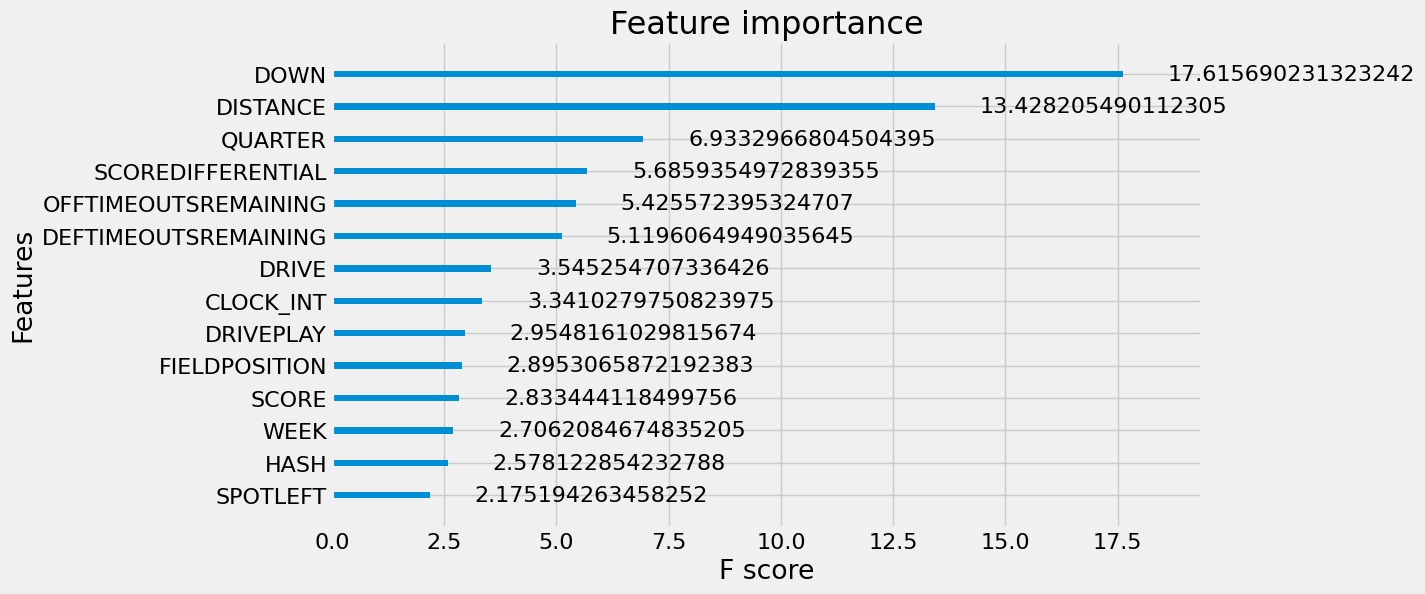

In [29]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png", bbox_inches = 'tight')
plt.show()

In [30]:
from sklearn.metrics import accuracy_score
y_test_pred = clf.predict(test_X)

In [31]:
test_accuracy = accuracy_score(test_y, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Test Accuracy = {test_accuracy}", file=text_file)

Test Accuracy: 0.7028788701792504


In [33]:

print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ TEST DATA Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())), file=text_file)



------------------ TEST DATA Confusion Matrix -----------------

     R    P
R  413  306
P  213  909
              precision    recall  f1-score   support

           R       0.66      0.57      0.61       719
           P       0.75      0.81      0.78      1122

    accuracy                           0.72      1841
   macro avg       0.70      0.69      0.70      1841
weighted avg       0.71      0.72      0.71      1841

